<a href="https://colab.research.google.com/github/manishmcsa/S5-Assigment-Solution/blob/main/MNIST_Data_BatchNorm_Maxpooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


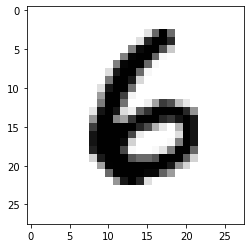

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


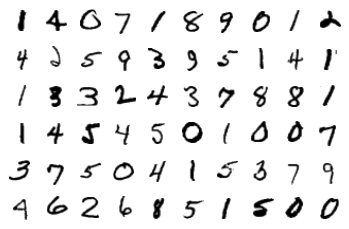

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #input Block
        self.convblock1=nn.Sequential(
                                        nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(6),
                                        nn.ReLU()
                                        ) # Input_size=28*28*1 kernel_size=3*3*6 Ouput_size=26*26*6
        self.convblock2=nn.Sequential(
                                        nn.Conv2d(in_channels=6,out_channels=12,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(12),
                                        nn.ReLU()
                                        ) # Input_size=26*26*6 kernel_size=3*3*12 Ouput_size=24*24*12
        self.convblock3=nn.Sequential(
                                        nn.Conv2d(in_channels=12,out_channels=24,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(24),
                                        nn.ReLU()
                                        ) # Input_size=24*24*12 kernel_size=3*3*24 Ouput_size=22*22*24
    
        self.pool1=nn.MaxPool2d(2,2) # Input_size=22*22*24 Ouput_size=11*11*24

        self.convblock4=nn.Sequential(
                                        nn.Conv2d(in_channels=24, out_channels=6, kernel_size=(1,1),padding=0,bias=False),
                                        nn.BatchNorm2d(6),
                                        nn.ReLU()
                                        ) # Input_size=11*11*24 kernel_size=1*1*6 Ouput_size=11*11*6
        
        self.convblock5=nn.Sequential(
                                        nn.Conv2d(in_channels=6,out_channels=12,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(12),
                                        nn.ReLU()
                                        ) # Input_size=11*11*6 kernel_size=3*3*12 Ouput_size=9*9*12

        self.convblock6=nn.Sequential(
                                        nn.Conv2d(in_channels=12,out_channels=24,kernel_size=(3,3),padding=0,bias=False),
                                        nn.BatchNorm2d(24),
                                        nn.ReLU()
                                      ) # Input_size=9*9*12 kernel_size=3*3*24 Ouput_size=7*7*24

        self.convblock7=nn.Sequential(
                                        nn.Conv2d(in_channels=24,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
                                        nn.BatchNorm2d(10),
                                        nn.ReLU()
                                      ) # Input_size=7*7*24 kernel_size=1*1*10 Ouput_size=7*7*10

        self.gap = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=7)
                                    ) # Input_size=7*7*10  Ouput_size=1*1*10

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)                  

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model= Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
       BatchNorm2d-2            [-1, 6, 26, 26]              12
              ReLU-3            [-1, 6, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]             648
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 24, 22, 22]           2,592
       BatchNorm2d-8           [-1, 24, 22, 22]              48
              ReLU-9           [-1, 24, 22, 22]               0
        MaxPool2d-10           [-1, 24, 11, 11]               0
           Conv2d-11            [-1, 6, 11, 11]             144
      BatchNorm2d-12            [-1, 6, 11, 11]              12
             ReLU-13            [-1, 6, 11, 11]               0
           Conv2d-14             [

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [26]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3637048304080963 Batch_id=468 Accuracy=82.05: 100%|██████████| 469/469 [00:08<00:00, 55.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3064, Accuracy: 9390/10000 (93.90%)

EPOCH: 1


Loss=0.19907808303833008 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:08<00:00, 56.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1489, Accuracy: 9707/10000 (97.07%)

EPOCH: 2


Loss=0.10219576954841614 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:08<00:00, 57.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9791/10000 (97.91%)

EPOCH: 3


Loss=0.10534391552209854 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:08<00:00, 57.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9787/10000 (97.87%)

EPOCH: 4


Loss=0.09561377018690109 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:08<00:00, 57.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1027, Accuracy: 9753/10000 (97.53%)

EPOCH: 5


Loss=0.09950380772352219 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:07<00:00, 58.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9853/10000 (98.53%)

EPOCH: 6


Loss=0.09610170871019363 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:07<00:00, 58.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9850/10000 (98.50%)

EPOCH: 7


Loss=0.06443937867879868 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:08<00:00, 57.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9849/10000 (98.49%)

EPOCH: 8


Loss=0.025667667388916016 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:08<00:00, 58.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9865/10000 (98.65%)

EPOCH: 9


Loss=0.049416642636060715 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:08<00:00, 58.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9845/10000 (98.45%)

EPOCH: 10


Loss=0.06257455796003342 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:08<00:00, 57.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9869/10000 (98.69%)

EPOCH: 11


Loss=0.10383764654397964 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:08<00:00, 58.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.016853997483849525 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:08<00:00, 58.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Loss=0.02611037902534008 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:07<00:00, 58.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.044221099466085434 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:07<00:00, 58.84it/s]



Test set: Average loss: 0.0438, Accuracy: 9884/10000 (98.84%)



Text(0.5, 1.0, 'Test Accuracy')

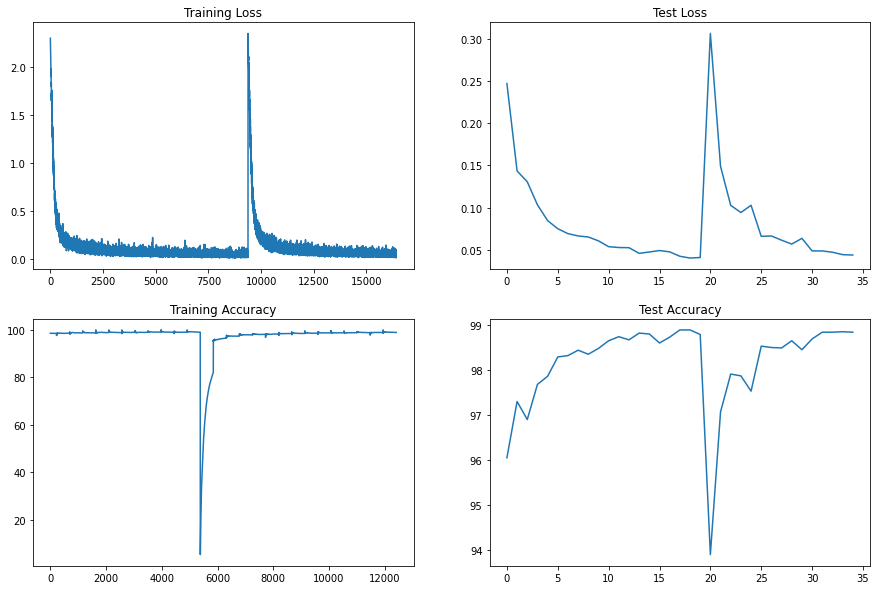

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")